# Data Parameters

In [1]:
# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
# Python nonsense that allows you to import from sibling directories
import sys
sys.path.append("../..")

import pandas as pd
from dotenv import load_dotenv

# Import the new PWWB implementation and dataset manager
from libs.pwwb import PWWBData
from libs.pwwb.utils.dataset_manager import create_dataset_manager

# Import the AirNow data class
from libs.airnowdata import AirNowData
from libs.hrrrdata import HRRRData

# Load environment variables (API keys, credentials)
load_dotenv()

import numpy as np
# Temporal train-test split function
def temporal_train_test_split(X, Y, train_size=0.8):
    """Split data temporally - first portion for training, last portion for testing"""
    split_idx = int(X.shape[0] * train_size)
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    Y_train = Y[:split_idx]
    Y_test = Y[split_idx:]
    
    print(f"Temporal split at index {split_idx}:")
    print(f"  Training: samples 0-{split_idx-1} ({train_size*100:.0f}% of time)")
    print(f"  Testing: samples {split_idx}-{len(X)-1} ({(1-train_size)*100:.0f}% of time)")
    
    return X_train, X_test, Y_train, Y_test
    
def temporal_train_test_valid_split(X, Y, train_size=0.7, test_size=0.2, valid_size=0.1):
    train_split = int(X.shape[0] * train_size)
    test_split = int(X.shape[0] * (train_size + valid_size))
    
    X_train = X[:train_split]
    X_valid = X[train_split:test_split]
    X_test = X[test_split:]
    Y_train = Y[:train_split]
    Y_valid = Y[train_split:test_split]
    Y_test = Y[test_split:]
    
    print(f"Temporal split at indices {train_split} and {test_split}:")
    print(f"  Training: samples 0-{train_split-1} ({train_size*100:.0f}% of time)")
    print(f"  Validation: samples {train_split}-{test_split-1} ({valid_size*100:.0f}% of time)")
    print(f"  Testing: samples {test_split}-{len(X)-1} ({test_size*100:.0f}% of time)")
    
    return X_train, X_test, X_valid, Y_train, Y_test, Y_valid

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

import joblib
def std_scale_train_test_valid(X_train, X_test, X_valid, save=False, save_path='data'):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
    scaled_valid = scaler.transform(X_valid.reshape(-1, 1)).reshape(X_valid.shape)

    if save:
        joblib.dump(scaler, save_path, compress=True)

    return scaled_train, scaled_test, scaled_valid

/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

In [4]:
# Adjust end date for AirNow
end_date_adj = pd.to_datetime(END_DATE) - pd.Timedelta(hours=1)

# ========== 2. Load AirNow Data ==========
airnow_data = AirNowData(
    start_date=START_DATE,
    end_date=end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    save_dir='data/two_years_with_hrrr/airnow_cache/airnow.json',
    processed_cache_dir='data/two_years_with_hrrr/airnow_cache/airnow_processed.npz',
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../libs/inputs/elevation.npy",
    mask_path="../libs/inputs/mask.npy",
    use_mask=False,
    force_reprocess=False
)
X_airnow = airnow_data.data
Y_targets = airnow_data.target_stations
print(f"✓ AirNow data shape: {X_airnow.shape}")
if Y_targets is not None:
    print(f"  Target stations shape: {Y_targets.shape}")
    print(f"  Number of sensors: {len(airnow_data.air_sens_loc)}")
    print(f"  Sensor names: {airnow_data.sensor_names}")
else:
    print("  No target stations available")

Elevation data not found at ../libs/inputs/elevation.npy. Using flat elevation.
Mask usage disabled. All sensors within extent will be included.
Loading processed AirNow data from cache: data/two_years_with_hrrr/airnow_cache/airnow_processed.npz
✓ Successfully loaded processed data from cache
  - Data shape: (17540, 5, 40, 40, 1)
  - Found 8 sensor locations
✓ AirNow data shape: (17540, 5, 40, 40, 1)
  Target stations shape: (17535, 5, 8)
  Number of sensors: 8
  Sensor names: ['Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Glendora - Laurel']


In [5]:
print("Data shape before trimming:")
print(f"  AirNow: {X_airnow.shape}")
print(f"  Targets: {Y_targets.shape}")

# Find the minimum number of timesteps across all datasets
min_timesteps = min(X_airnow.shape[0], Y_targets.shape[0])
print(f"Minimum timesteps across all datasets: {min_timesteps}")

# Trim all datasets to the same number of timesteps
X_airnow = X_airnow[:min_timesteps]
Y_targets = Y_targets[:min_timesteps]  # Don't forget to trim Y_targets too!

print(f"Data shapes after trimming:")
print(f"  AirNow: {X_airnow.shape}")
print(f"  Y_targets: {Y_targets.shape}")

# Display the number of channels from each source
airnow_channels = X_airnow.shape[4]

# Create combined channel names
all_channel_names = ["AirNow_PM25"]
print(f"Channel names: {all_channel_names}")

Data shape before trimming:
  AirNow: (17540, 5, 40, 40, 1)
  Targets: (17535, 5, 8)
Minimum timesteps across all datasets: 17535
Data shapes after trimming:
  AirNow: (17535, 5, 40, 40, 1)
  Y_targets: (17535, 5, 8)
Channel names: ['AirNow_PM25']


# AirNow Investigation

In [6]:
# one frame, one station
# since x is [0, 1, 2, 3, 4] and y is [5, 6, 7, 8, 9], t-1 -> t should be the last x frame and first y frame
# LA is station 4
one_frame_X = X_airnow[:, [-1], :, :, :].copy()
one_frame_Y = Y_targets[:, 0, [4]].copy()

# print data
print(f'X shape: {one_frame_X.shape}, Y shape: {one_frame_Y.shape}')
'''
print('\nSecond sample:')
for i in range(one_frame_X.shape[2]):
    print(one_frame_X[1, :, i].reshape(-1))
'''
print(f"Target for first sample (should match second X sample): {one_frame_Y[0]}")

# validate t-1 != t (X current, Y current)
print('\nTesting that next frame of X matches previous frame in Y')
print('For same frame:')
match = np.where(np.isclose(one_frame_X[0], one_frame_Y[0]))
print(
    "Success: no matches found" 
    if match[0].size == 0 
    else f"Error: matches found on indexes {list(zip(*match))}"
)

# validate t == t (X future, Y current)
print('\nFor Y current, X one index ahead:')
match = np.where(np.isclose(one_frame_X[1], one_frame_Y[0]))
print(
    "Error: no matches found" 
    if match[0].size == 0 
    else f"Success: matches found on indexes {list(zip(*match))}"
)

# validate t == t (X future, Y current)
print('\nFor Y current, ANY X frame with the LA station:')
match = np.where(np.isclose(one_frame_X[:, 0, 11, 17], one_frame_Y))
print(
    "Error: no matches found" 
    if match[0].size == 0 
    else f"Success: matches found on indexes {list(zip(*match))}"
)

X shape: (17535, 1, 40, 40, 1), Y shape: (17535, 1)
Target for first sample (should match second X sample): [6.6]

Testing that next frame of X matches previous frame in Y
For same frame:
Success: no matches found

For Y current, X one index ahead:
Error: no matches found

For Y current, ANY X frame with the LA station:
Success: matches found on indexes [(16568, 0)]


In [7]:
# targets not in the grid? should be 10ths precision
for x in range(40):
    print(one_frame_X[0, 0, x, :].T)

[[7.74586856 7.80858342 7.80201731 7.85306184 7.99222447 7.94728792
  7.67281462 7.57090272 7.45074961 7.42958202 7.36646441 7.21713091
  7.10205825 7.02338844 6.87627516 6.75007856 6.63268427 6.48514785
  6.35911756 6.27225497 6.20197747 6.16620541 6.06341583 6.01939156
  6.03628281 5.95402562 5.94612035 5.9738496  5.94462496 5.92666267
  5.94797519 5.91984092 5.90357079 5.89828537 5.95688949 5.92886861
  5.9367399  5.96426856 5.99292552 6.00339289]]
[[7.69326407 7.86300033 7.88146553 7.919785   8.06229581 7.95154864
  7.38687251 7.74510354 7.59643311 7.44369837 7.33853363 7.22961399
  7.11751596 6.97965008 6.85307747 6.7349496  6.61054543 6.48229053
  6.32602314 6.20954028 6.15891553 6.10058189 6.03720047 5.99730571
  5.98853609 5.92457321 5.87089245 5.8776819  5.85976497 5.89542637
  5.8611123  5.88930226 5.90958534 5.89532894 5.92587646 5.91543695
  5.93732719 5.93967352 5.95269917 5.97109237]]
[[7.675396   7.79988076 7.8964477  7.85942673 7.92637183 7.40871872
  6.42185594 7.21479


Examining PM2.5 values at ground sensor locations:


,Sensor,Coords,Grid Value,Target
0,Simi Valley - Cochran Street,"(1, 8)",7.596433,4.1
1,Reseda,"(4, 12)",7.052654,12.0
2,Santa Clarita,"(5, 4)",7.828238,9.4
3,North Holywood,"(8, 12)",6.485969,5.1
4,Los Angeles - N. Main Street,"(11, 17)",5.154740,6.6
5,Compton,"(12, 23)",4.708209,7.6
6,Long Beach Signal Hill,"(13, 28)",5.076130,4.2
7,Glendora - Laurel,"(20, 14)",6.533259,3.8


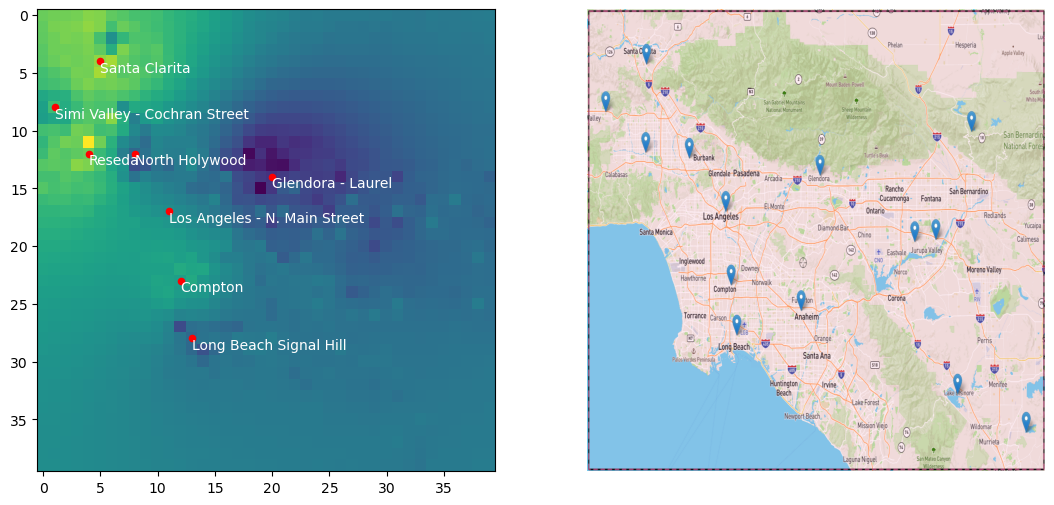

In [8]:
import pandas as pd

print("\nExamining PM2.5 values at ground sensor locations:")
sensor_info = []
for i, d in enumerate(airnow_data.air_sens_loc.items()):
    site, yx = d
    y, x = yx
    sensor_info.append([
        site, 
        (x, y), 
        one_frame_X[0, 0, x, y][0], 
        Y_targets[0, 0, i]
    ])

df = pd.DataFrame(sensor_info, columns=["Sensor", "Coords", "Grid Value", "Target"])
display(df)

import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('/home/mgraca/Pictures/Screenshots/approx_sites.png')

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# subplot 1
axes[0].imshow(one_frame_X[0, 0], aspect='auto')
for site, yx in airnow_data.air_sens_loc.items():
    y, x = yx
    axes[0].text(x, y, site, color='white', fontsize=10, ha='left', va='top')
    axes[0].scatter(x, y, color='red', s=20)

# subplot 2
axes[1].imshow(img, aspect='auto')
axes[1].axis('off')

plt.show()

In [9]:
# theory: gaussian smoothing messes up the real data
print(
    f"Average PM2.5 error between observed and interpolated pixel for LA sensor: " 
    f"{np.sum(np.abs(one_frame_X[1:, 0, 17, 11][0] - one_frame_Y[:-1])) / (len(one_frame_Y) - 1):.2f}\n"
)

sensor_info = []
running_sum = 0
denom = 0
for i, d in enumerate(airnow_data.air_sens_loc.items()):
    site, xy = d
    y, x = yx
    error = np.sum(np.abs(one_frame_X[1:, 0, x, y][0] - Y_targets[:-1, 0, i])) / (len(Y_targets) - 1)
    running_sum += error
    denom += 1
    sensor_info.append([
        site,
        error
    ])

df = pd.DataFrame(sensor_info, columns=["Sensor", "Average Error"])
display(df)
print(f"\nAverage PM2.5 error between observed and interpolated pixel: {running_sum / denom:.2f}")

Average PM2.5 error between observed and interpolated pixel for LA sensor: 6.42



,Sensor,Average Error
0,Simi Valley - Cochran Street,3.550751
1,Reseda,5.188947
2,Santa Clarita,4.203161
3,North Holywood,5.328427
4,Los Angeles - N. Main Street,6.291827
5,Compton,6.388816
6,Long Beach Signal Hill,4.540990
7,Glendora - Laurel,5.435785



Average PM2.5 error between observed and interpolated pixel: 5.12


In [10]:
# making sure I didn't mess up x,y coordinates
print(
    f"Average PM2.5 error between observed and interpolated pixel for LA sensor: " 
    f"{np.sum(np.abs(one_frame_X[1:, 0, 11, 17][0] - one_frame_Y[:-1])) / (len(one_frame_Y) - 1):.2f}\n"
)

sensor_info = []
running_sum = 0
denom = 0
for i, d in enumerate(airnow_data.air_sens_loc.items()):
    site, xy = d
    y, x = yx
    error = np.sum(np.abs(one_frame_X[1:, 0, y, x][0] - Y_targets[:-1, 0, i])) / (len(Y_targets) - 1)
    running_sum += error
    denom += 1
    sensor_info.append([
        site,
        error
    ])

df = pd.DataFrame(sensor_info, columns=["Sensor", "Average Error"])
display(df)
print(f"\nAverage PM2.5 error between observed and interpolated pixel: {running_sum / denom:.2f}")

Average PM2.5 error between observed and interpolated pixel for LA sensor: 7.05



,Sensor,Average Error
0,Simi Valley - Cochran Street,3.612397
1,Reseda,6.165833
2,Santa Clarita,5.174620
3,North Holywood,6.241624
4,Los Angeles - N. Main Street,7.460447
5,Compton,7.334985
6,Long Beach Signal Hill,5.135426
7,Glendora - Laurel,5.610237



Average PM2.5 error between observed and interpolated pixel: 5.84
